# Figure 3: Orthogonal functions

This notebook generates figure 3 from 'Meta-Learning the Inductive Bias of Simple Neural Circuits', Dorrell et al. 2022.

We show how to generate a set of orthogonal fuctions that a network finds easy to generalise.

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from geomloss import SamplesLoss
from scipy import special

/Users/will/opt/anaconda3/envs/inductive_II/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Function to generate N datapoints on the sphere
def new_data(N):
  x = torch.normal(0,1,[N,3])
  return x/torch.norm(x, dim = 1)[:,np.newaxis]

def new_data_flat(N):
    x = torch.zeros([N,2])
    for i in range(N):
        theta = np.random.uniform(0,2*np.pi)
        r = np.random.uniform(0,1)
        x[i,0] = np.sqrt(r)*np.cos(theta)
        x[i,1] = np.sqrt(r)*np.sin(theta)
    return x

# Function to map points on sphere to 2D
def threeto2D(x):
  y = np.zeros([x.shape[0], 2])
  y[:,0] = np.arctan2(x[:,1],x[:,0])+torch.pi
  y[:,1] = np.arctan2(x[:,2],np.sqrt(np.power(x[:,0],2) + np.power(x[:,1],2)))+torch.pi/2
  return y

# A useful default plotting function
def plotty_dotty(Losses, y, fly_label, z_init, z):
  plt.figure(figsize = (8,8))

  # Plot losses
  plt.subplot(2,2,1)
  plt.plot(Losses)
  plt.title('Loss')

  # Plot three different labellings
  plt.subplot(2,2,2)
  plt.scatter(y[:,0], y[:,1], c = fly_label)
  plt.colorbar()
  plt.title('Fly Labelling')
  plt.subplot(2,2,3)
  plt.scatter(y[:,0], y[:,1], c = z_init)
  plt.colorbar()
  plt.title('Initial Network Labelling')
  plt.subplot(2,2,4)
  plt.scatter(y[:,0], y[:,1], c = z)
  plt.colorbar()
  plt.title('Final Network Labelling')

In [3]:
# 1. Create the neural network
input_size_gen = 2
hidden_size_gen = 20
output_size_gen = 1
layers = 4

class NeuralNet(nn.Module):
    def __init__(self,input_size_gen,hidden_size_gen, output_size_gen):
        super(NeuralNet,self).__init__()
        self.linear1 = nn.Linear(input_size_gen,hidden_size_gen, bias = True)
        self.linearh = nn.Linear(hidden_size_gen,hidden_size_gen, bias = True)
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        self.sigmoid = nn.Sigmoid()
        self.linear2 = nn.Linear(hidden_size_gen,output_size_gen, bias = True)

    def forward(self, x):
        out = self.linear1(x)
        for i in range(layers-1):
            out = self.relu(out)
            out = self.linearh(out)
        #out = self.relu(out)
        out = self.relu(out)
        out = self.linear2(out)
        #out = torch.cos(out)
        return out


## 3 orthogonal functions that ridge regression finds easy to learn

In [4]:
# Create normally distributed weight matrix to K kenyon cells
K = 20

def orthog_3_fun(z1, z2, z3, y):
  plt.figure(figsize = (8, 8))

  # Plot three different labellings
  plt.subplot(2,2,1)
  plt.scatter(y[:,0], y[:,1], c = z1)
  plt.colorbar()
  plt.title('Eigenfunction 1' + str())
  plt.subplot(2,2,2)
  plt.scatter(y[:,0], y[:,1], c = z2)
  plt.colorbar()
  plt.title('Eigenfunction 2' +str())
  plt.subplot(2,2,3)
  plt.scatter(y[:,0], y[:,1], c = z3)
  plt.colorbar()
  plt.title('Eigenfunction 3' +str())

In [5]:
def fly_simple_ridge_learnt(x, z):
  w = torch.matmul(torch.inverse(torch.matmul(torch.transpose(x,0,1), x) + 0.001*torch.eye(2)),torch.matmul(torch.transpose(x,0,1), z))
  fly_label = torch.matmul(x, w) 
  return fly_label

def loss_simple_ridge_learnt1(x_tr, x_te, z_tr, z_te, distr):
  w = torch.matmul(torch.inverse(torch.matmul(torch.transpose(x_tr,0,1), x_tr) + 0.001*torch.eye(2)),torch.matmul(torch.transpose(x_tr,0,1), z_tr))
  fly_label = torch.matmul(x_te, w)

  loss = SamplesLoss(loss="sinkhorn", p=2, blur=.05)

  return (loss(z_tr, distr) + loss(z_te, distr)) + torch.mean((z_te - fly_label)**2)

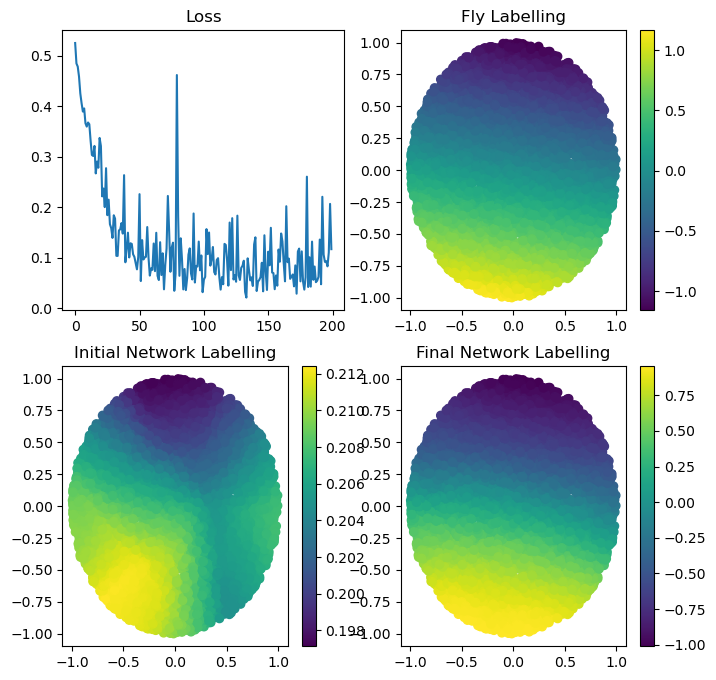

In [6]:
# Let's try and find an approximation to the first eigenfunction!
# Set up optimiser and loss
model_ridge1 = NeuralNet(input_size_gen, hidden_size_gen, output_size_gen)
optimizer = optim.Adagrad(model_ridge1.parameters(), lr=0.01)

# Parameter choices
M = 30 # Number of datapoints for each training step
T = 200 # Number of steps
M_plot = 5000 # number of points for plotting
Losses = np.zeros(T)

# Normal distribution
#distr = torch.normal(0, 1, [M,1])
distr = 2 * torch.rand(M//2, 1) - 1

# Get initial labelling
x_plot = new_data_flat(M_plot)
z_init = model_ridge1(x_plot).detach().numpy()

for step in range(T):
  optimizer.zero_grad()
  x_tr = new_data_flat(M//5)
  x_te = new_data_flat(M//5*4)
  z_tr = model_ridge1(x_tr)
  z_te = model_ridge1(x_te)
  loss = loss_simple_ridge_learnt1(x_tr, x_te, z_tr, z_te, distr)
  loss.backward()
  optimizer.step()
  Losses[step] = loss.item()

z = model_ridge1(x_plot).detach()
fly_label = fly_simple_ridge_learnt(x_plot, z).numpy()
z = model_ridge1(x_plot).detach().numpy()
x1_ridge = x_plot
z1_ridge = z

plotty_dotty(Losses, x_plot, fly_label, z_init, z)

In [7]:
def loss_orthog_ridge_learnt2(x_tr, x_te, z_tr, z_te, z_func, z1, distr):
  w = torch.matmul(torch.inverse(torch.matmul(torch.transpose(x_tr,0,1), x_tr) + 0.001*torch.eye(2)),torch.matmul(torch.transpose(x_tr,0,1), z_tr))
  fly_label = torch.matmul(x_te, w)

  loss = SamplesLoss(loss="sinkhorn", p=2, blur=.05)
  orthog_loss = torch.sum(torch.multiply(z1[:,0], z_func[:,0]))**2

  #print(f"Loss ridge: {torch.mean((z_te - fly_label)**2)}, loss orthog:{orthog_loss}, loss distr:{(loss(z_tr, distr) + loss(z_te, distr))}")
  #torch.linalg.norm(w)**2

  return (loss(z_tr, distr) + loss(z_te, distr))*1000000 + torch.mean((z_te - fly_label)**2) + orthog_loss

Orthogonality: 0.00619971938431263


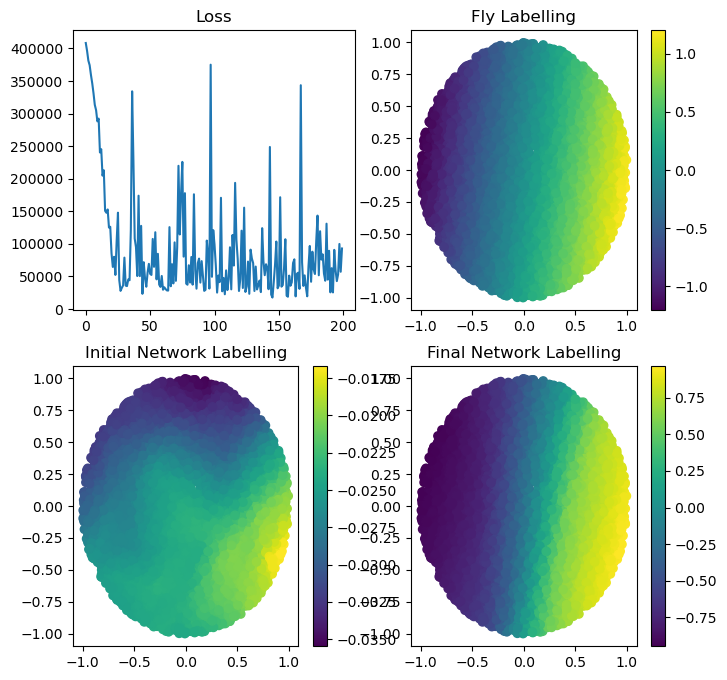

In [8]:
# Next up, let's try to get the second eigenfunction

# Set up optimiser and loss
model_ridge2 = NeuralNet(input_size_gen, hidden_size_gen, output_size_gen)
optimizer = optim.Adagrad(model_ridge2.parameters(), lr=0.01)

K = 100

# Parameter choices
M = 30 # Number of datapoints for each training step
T = 200 # Number of steps
M_plot = 5000 # number of points for plotting
Losses = np.zeros(T)

# Normal distribution
#distr = torch.normal(0, 1, [M,1])
distr = 2 * torch.rand(M//2, 1) - 1

# Get initial labelling
x_plot = new_data_flat(M_plot)
z_init = model_ridge2(x_plot).detach().numpy()
z_orth = torch.tensor(z1_ridge)

for step in range(T):
  optimizer.zero_grad()
  x_tr = new_data_flat(M//5)
  x_te = new_data_flat(M)
  z_tr = model_ridge2(x_tr)
  z_te = model_ridge2(x_te)
  z_comp = model_ridge2(x1_ridge)
  J = np.transpose(np.random.multivariate_normal(np.zeros(3),[[1,0,0],[0,1,0],[0,0,1]], (K)))
  J = torch.from_numpy(J).float()
  loss = loss_orthog_ridge_learnt2(x_tr, x_te, z_tr, z_te, z_comp, z_orth, distr)
  loss.backward(retain_graph=True)
  optimizer.step()
  Losses[step] = loss.item()


z = model_ridge2(x_plot).detach()
fly_label = fly_simple_ridge_learnt(x_plot, z).numpy()
z = model_ridge2(x_plot).detach().numpy()

plotty_dotty(Losses, x_plot, fly_label, z_init, z)
x2_ridge = x_plot
z2_ridge = z

x_plot = new_data_flat(M_plot)
z_learnt = model_ridge2(x_plot)
z_1 = model_ridge1(x_plot)

print(f'Orthogonality: {torch.sum(torch.multiply(z_learnt, z_1))/M_plot}')

In [9]:
def loss_orthog_ridge_learnt2(x_tr, x_te, z_tr, z_te, z_func1, z_func2, z1, z2, distr):
  w = torch.matmul(torch.inverse(torch.matmul(torch.transpose(x_tr,0,1), x_tr) + 0.001*torch.eye(2)),torch.matmul(torch.transpose(x_tr,0,1), z_tr))
  fly_label = torch.matmul(x_te, w)

  loss = SamplesLoss(loss="sinkhorn", p=2, blur=.05)
  orthog_loss1 = torch.sum(torch.multiply(z1[:,0], z_func1[:,0]))**2
  orthog_loss2 = torch.sum(torch.multiply(z2[:,0], z_func2[:,0]))**2

  orthog_loss = orthog_loss1 + orthog_loss2

  return (loss(z_tr, distr) + loss(z_te, distr))*1000000 + torch.mean((z_te - fly_label)**2) + orthog_loss*10

Orthogonality: 0.011820197105407715


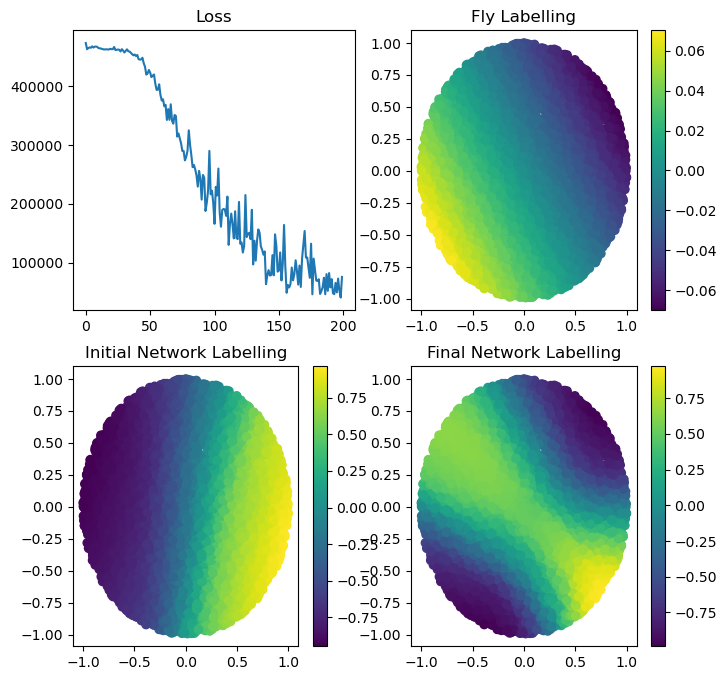

In [10]:
# Next up, let's try to get the second eigenfunction

# Set up optimiser and loss
model_ridge3 = NeuralNet(input_size_gen, hidden_size_gen, output_size_gen)
optimizer = optim.Adagrad(model_ridge3.parameters(), lr=0.01)

K = 100

# Parameter choices
M = 50 # Number of datapoints for each training step
T = 200 # Number of steps
M_plot = 5000 # number of points for plotting
Losses = np.zeros(T)

# Normal distribution
#distr = torch.normal(0, 1, [M,1])
distr = 2 * torch.rand(M//2, 1) - 1

# Get initial labelling
x_plot = new_data_flat(M_plot)
z_init = model_ridge2(x_plot).detach().numpy()
z_orth1 = torch.tensor(z1_ridge)
z_orth2 = torch.tensor(z2_ridge)

for step in range(T):
  optimizer.zero_grad()
  x_tr = new_data_flat(M//5)
  x_te = new_data_flat(M)
  z_tr = model_ridge3(x_tr)
  z_te = model_ridge3(x_te)
  z_comp1 = model_ridge3(x1_ridge)
  z_comp2 = model_ridge3(x2_ridge)
  J = np.transpose(np.random.multivariate_normal(np.zeros(3),[[1,0,0],[0,1,0],[0,0,1]], (K)))
  J = torch.from_numpy(J).float()
  loss = loss_orthog_ridge_learnt2(x_tr, x_te, z_tr, z_te, z_comp1, z_comp2, z_orth1, z_orth2, distr)
  loss.backward(retain_graph=True)
  optimizer.step()
  Losses[step] = loss.item()


z = model_ridge3(x_plot).detach()
fly_label = fly_simple_ridge_learnt(x_plot, z).numpy()
z = model_ridge3(x_plot).detach().numpy()

plotty_dotty(Losses, x_plot, fly_label, z_init, z)
x3_ridge = x_plot
z3_ridge = z

x_plot = new_data_flat(M_plot)
z_learnt3 = model_ridge3(x_plot)
z_1r = model_ridge1(x_plot)
z_2r = model_ridge2(x_plot)

print(f'Orthogonality: {torch.sum(torch.multiply(z_learnt3, z_1r))/M_plot}')

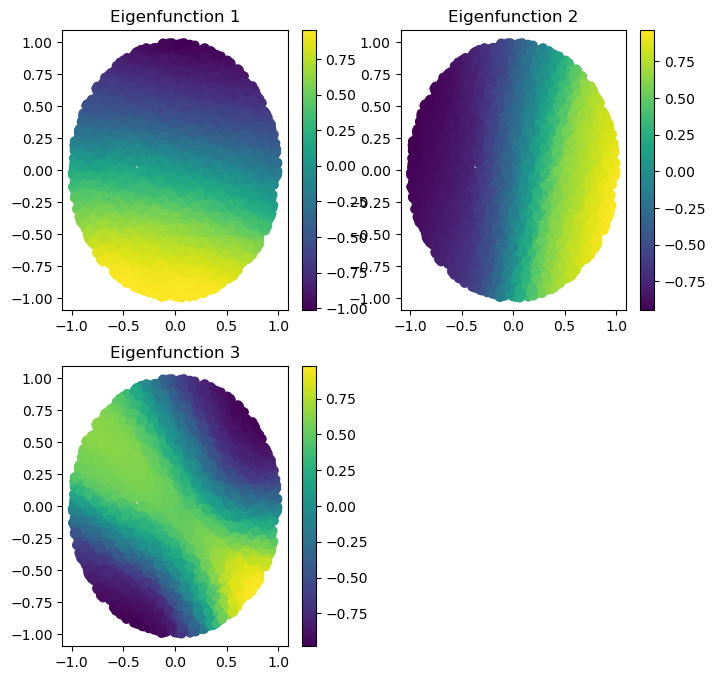

In [11]:
M_plot = 5000
x_plot = new_data_flat(M_plot)
z1 = model_ridge1(x_plot).detach().numpy()
z2 = model_ridge2(x_plot).detach().numpy()
z3 = model_ridge3(x_plot).detach().numpy()

orthog_3_fun(z1, z2, z3, x_plot)

In [12]:
M_plot = 5000
x_plot = new_data_flat(M_plot)
z = model_ridge1(x_plot).detach()
fly_label = fly_simple_ridge_learnt(x_plot, z).numpy()
z = z.numpy()
MSE_1 = np.sum((fly_label - z)**2)/(2*M_plot)

z = model_ridge2(x_plot).detach()
fly_label = fly_simple_ridge_learnt(x_plot, z).numpy()
z = z.numpy()
MSE_2 = np.sum((fly_label - z)**2)/(2*M_plot)

z = model_ridge3(x_plot).detach()
fly_label = fly_simple_ridge_learnt(x_plot, z).numpy()
z = z.numpy()
MSE_3 = np.sum((fly_label - z)**2)/(2*M_plot)

print(MSE_1)
print(MSE_2)
print(MSE_3)

0.0021527402877807617
0.0144214599609375
0.149929736328125


## 6 orthogonal functions that kernel regression is good at learning

In [13]:
def fly_simple_kernel_learnt(x, z, J):
  y = torch.nn.functional.relu(torch.matmul(x,J))
  w = torch.matmul(torch.inverse(torch.matmul(torch.transpose(y,0,1), y) + 0.001*torch.eye(K)),torch.matmul(torch.transpose(y,0,1), z))
  fly_label = torch.matmul(y, w) 
  return fly_label

def loss_simple_kernel_learnt(x_tr, x_te, z_tr, z_te, distr, J):
  y_tr = torch.nn.functional.relu(torch.matmul(x_tr,J))
  w = torch.matmul(torch.inverse(torch.matmul(torch.transpose(y_tr,0,1), y_tr) + 0.001*torch.eye(K)),torch.matmul(torch.transpose(y_tr,0,1), z_tr))
  y_te = torch.nn.functional.relu(torch.matmul(x_te,J))
  fly_label = torch.matmul(y_te, w)

  loss = SamplesLoss(loss="sinkhorn", p=2, blur=.05)

  return (loss(z_tr, distr) + loss(z_te, distr)) + torch.mean((z_te - fly_label)**2)

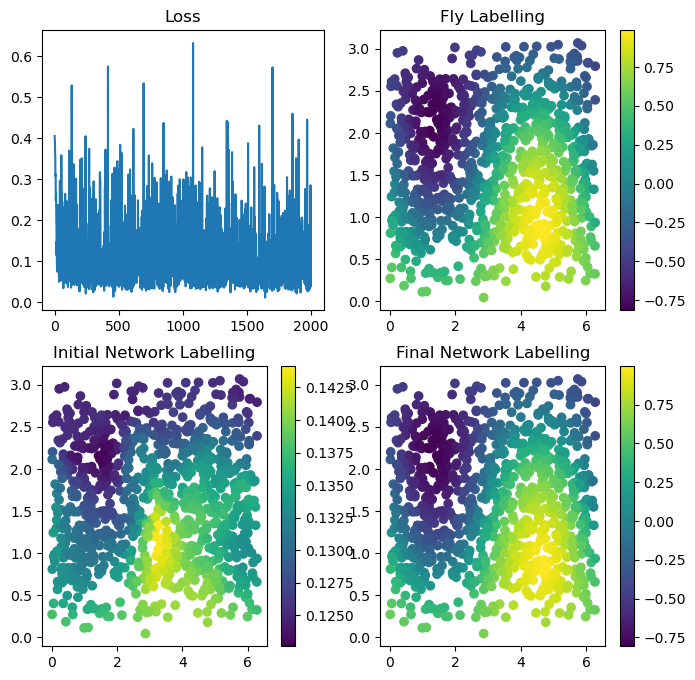

In [14]:
input_size_gen = 3
c = 1
# Let's try and find an approximation to the first eigenfunction!

# Set up optimiser and loss
model = NeuralNet(input_size_gen, hidden_size_gen, output_size_gen)
optimizer = optim.Adagrad(model.parameters(), lr=0.01)

# Parameter choices
M = 30 # Number of datapoints for each training step
T = 2000 # Number of steps
M_plot = 1000 # number of points for plotting
Losses = np.zeros(T)

# Normal distribution
#distr = torch.normal(0, 1, [M,1])
distr = 2 * torch.rand(M//2, 1) - 1

# Get initial labelling
x_plot = new_data(M_plot)
z_init = model(x_plot).detach().numpy()

for step in range(T):
  optimizer.zero_grad()
  x_tr = new_data(M//5)
  x_te = new_data(M//5*4)
  z_tr = model(x_tr)
  z_te = model(x_te)
  #z_tr = z_tr/(torch.norm(z_tr))*M//5
  #z_te = z_te/(torch.norm(z_te))*M//5*4
  J = np.transpose(np.random.multivariate_normal(np.zeros(3),[[1,0,0],[0,1,0],[0,0,c]], (K)))
  J = torch.from_numpy(J).float()
  loss = loss_simple_kernel_learnt(x_tr, x_te, z_tr, z_te, distr, J)
  loss.backward()
  optimizer.step()
  Losses[step] = loss.item()

z = model(x_plot).detach()
fly_label = fly_simple_kernel_learnt(x_plot, z, J).numpy()
z = model(x_plot).detach().numpy()
y = threeto2D(x_plot.detach().numpy())
x1 = x_plot
z1 = z

plotty_dotty(Losses, y, fly_label, z_init, z)

In [15]:
def loss_orthog_kernel_learnt(x_tr, x_te, z_tr, z_te, z_func, z1, distr, J, lambda2, lambda3):
  y_tr = torch.nn.functional.relu(torch.matmul(x_tr,J))
  w = torch.matmul(torch.inverse(torch.matmul(torch.transpose(y_tr,0,1), y_tr) + 0.001*torch.eye(K)),torch.matmul(torch.transpose(y_tr,0,1), z_tr))
  y_te = torch.nn.functional.relu(torch.matmul(x_te,J))
  fly_label = torch.matmul(y_te, w)
  label_loss = torch.mean((z_te - fly_label)**2)

  loss = SamplesLoss(loss="sinkhorn", p=2, blur=.05)
  dist_loss = 1000000*loss(z_te, distr)

  orthog_loss = torch.sum(torch.multiply(z1[:,0], z_func[:,0]))**2
  '''
  if dist_loss > 0:
    lambda2 = lambda2*torch.exp((torch.log(dist_loss*10)+2))
  else:
    lambda2 = torch.tensor([1])
  lambda3 = lambda3*torch.exp((torch.log((orthog_loss))+2)*0.01)
  '''
  #print(f"Class Loss: {label_loss}, Orthog Loss: {orthog_loss}, Dist Loss: {dist_loss}")

  return dist_loss + label_loss + orthog_loss


Orthogonality: -3.9588427543640137


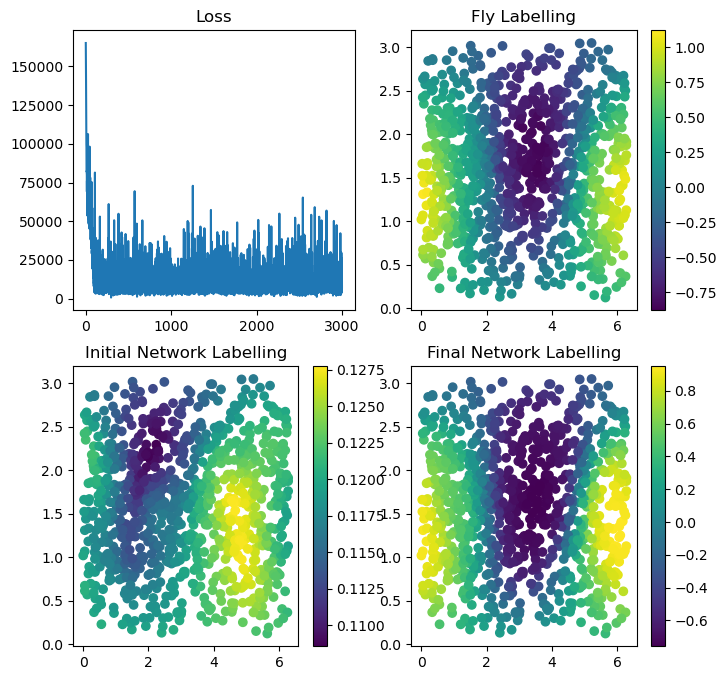

In [16]:
# Next up, let's try to get the second eigenfunction

# Set up optimiser and loss
model2 = NeuralNet(input_size_gen, hidden_size_gen, output_size_gen)
optimizer = optim.Adagrad(model2.parameters(), lr=0.01)

K = 100

# Parameter choices
M = 30 # Number of datapoints for each training step
T = 3000 # Number of steps
M_plot = 1000 # number of points for plotting
Losses = np.zeros(T)

# Normal distribution
#distr = torch.normal(0, 1, [M,1])
distr = 2 * torch.rand(M//2, 1) - 1

# Get initial labelling
x_plot = new_data(M_plot)
z_init = model2(x_plot).detach().numpy()
z_orth = torch.tensor(z1)

lambda2 = 10
lambda3 = 30

for step in range(T):
  optimizer.zero_grad()
  x_tr = new_data(M//5)
  x_te = new_data(M)
  z_tr = model2(x_tr)
  z_te = model2(x_te)
  z_comp = model2(x1)
  J = np.transpose(np.random.multivariate_normal(np.zeros(3),[[1,0,0],[0,1,0],[0,0,c]], (K)))
  J = torch.from_numpy(J).float()
  loss = loss_orthog_kernel_learnt(x_tr, x_te, z_tr, z_te, z_comp, z_orth, distr, J, lambda2, lambda3)
  loss.backward(retain_graph=True)
  optimizer.step()
  Losses[step] = loss.item()


z = model2(x_plot).detach()
fly_label = fly_simple_kernel_learnt(x_plot, z, J).numpy()
z = model2(x_plot).detach().numpy()
y = threeto2D(x_plot.detach().numpy())

plotty_dotty(Losses, y, fly_label, z_init, z)
x2 = x_plot
z2 = z

x_plot = new_data(M_plot)
z_learnt = model2(x_plot)
z_1 = model(x_plot)

print(f'Orthogonality: {torch.sum(torch.multiply(z_learnt, z_1))}')

In [17]:
def loss_orthog_kernel_learnt_2(x_tr, x_te, z_tr, z_te, z_func1,z_func2, z1, z2, distr, J):
  y_tr = torch.nn.functional.relu(torch.matmul(x_tr,J))
  w = torch.matmul(torch.inverse(torch.matmul(torch.transpose(y_tr,0,1), y_tr) + 0.001*torch.eye(K)),torch.matmul(torch.transpose(y_tr,0,1), z_tr))
  y_te = torch.nn.functional.relu(torch.matmul(x_te,J))
  fly_label = torch.matmul(y_te, w)

  label_loss = torch.mean((z_te - fly_label)**2)
  loss = SamplesLoss(loss="sinkhorn", p=2, blur=.05)
  dist_loss = 1000000*(loss(z_te, distr))

  orthog_loss_1 = torch.sum(torch.multiply(z1[:,0], z_func1[:,0]))**2
  orthog_loss_2 = torch.sum(torch.multiply(z2[:,0], z_func2[:,0]))**2
  orthog_loss = orthog_loss_1+orthog_loss_2

  #print(f"Class Loss: {label_loss}, Orthog Loss: {orthog_loss}, Dist Loss: {dist_loss}")
  #print(lambda3)

  return dist_loss + label_loss + orthog_loss

Orthogonality: 0.06484291702508926
Orthogonality: 0.0024427101016044617


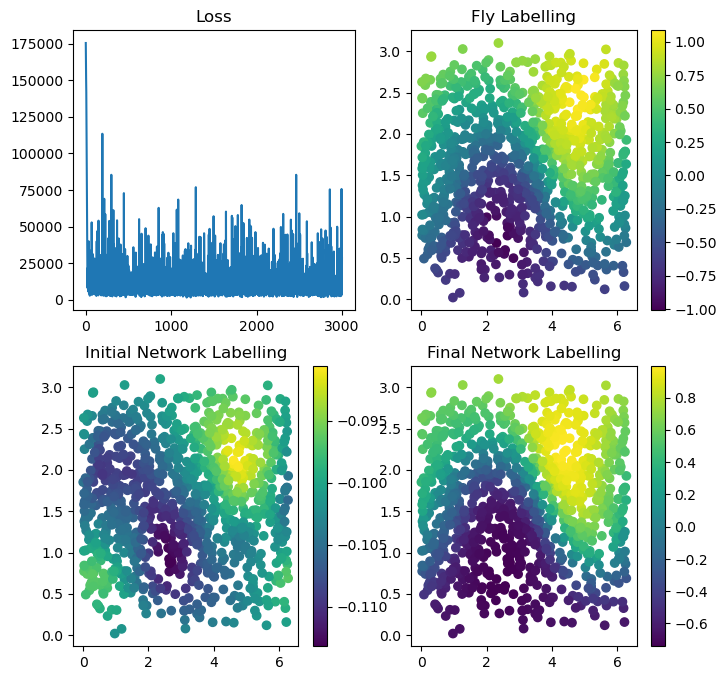

In [18]:
# Next up, let's try to get the second eigenfunction

# Set up optimiser and loss
model3 = NeuralNet(input_size_gen, hidden_size_gen, output_size_gen)
optimizer = optim.Adagrad(model3.parameters(), lr=0.01)

# Parameter choices
M = 30 # Number of datapoints for each training step
T = 3000 # Number of steps
M_plot = 1000 # number of points for plotting
Losses = np.zeros(T)

# Get initial labelling
x_plot = new_data(M_plot)
z_init = model3(x_plot).detach().numpy()

z_orth_1 = torch.tensor(z1)
z_orth_2 = torch.tensor(z2)

for step in range(T):
  optimizer.zero_grad()
  x_tr = new_data(M//5)
  x_te = new_data(M)
  z_tr = model3(x_tr)
  z_te = model3(x_te)
  z_comp_1 = model3(x1)
  z_comp_2 = model3(x2)
  J = np.transpose(np.random.multivariate_normal(np.zeros(3),[[1,0,0],[0,1,0],[0,0,c]], (K)))
  J = torch.from_numpy(J).float()
  loss = loss_orthog_kernel_learnt_2(x_tr, x_te, z_tr, z_te, z_comp_1, z_comp_2, z_orth_1, z_orth_2, distr, J)
  loss.backward()
  optimizer.step()
  Losses[step] = loss.item()

z = model3(x_plot).detach()
fly_label = fly_simple_kernel_learnt(x_plot, z, J).numpy()
z = model3(x_plot).detach().numpy()
y = threeto2D(x_plot.detach().numpy())


plotty_dotty(Losses, y, fly_label, z_init, z)
x3 = x_plot
z3 = z

x_plot = new_data(M_plot)
z_learnt = model3(x_plot)
z_1 = model(x_plot)
z_2 = model2(x_plot)

print(f'Orthogonality: {torch.sum(torch.multiply(z_learnt, z_1))**2/M_plot}')
print(f'Orthogonality: {torch.sum(torch.multiply(z_learnt, z_2))**2/M_plot}')

In [19]:
def loss_orthog_kernel_learnt_3(x_tr, x_te, z_tr, z_te, z_func1, z_func2, z_func3, z1, z2, z3, distr, J):
  y_tr = torch.nn.functional.relu(torch.matmul(x_tr,J))
  w = torch.matmul(torch.inverse(torch.matmul(torch.transpose(y_tr,0,1), y_tr) + 0.001*torch.eye(K)),torch.matmul(torch.transpose(y_tr,0,1), z_tr))
  y_te = torch.nn.functional.relu(torch.matmul(x_te,J))
  fly_label = torch.matmul(y_te, w)

  label_loss = torch.mean((z_te - fly_label)**2)
  loss = SamplesLoss(loss="sinkhorn", p=2, blur=.05)
  dist_loss = 1000000*(loss(z_te, distr))

  orthog_loss_1 = torch.sum(torch.multiply(z1[:,0], z_func1[:,0]))**2
  orthog_loss_2 = torch.sum(torch.multiply(z2[:,0], z_func2[:,0]))**2
  orthog_loss_3 = torch.sum(torch.multiply(z3[:,0], z_func3[:,0]))**2
  orthog_loss = (orthog_loss_1 + orthog_loss_2 + orthog_loss_3)

  #print(f"Label loss: {label_loss}, Orthog loss: {orthog_loss}, Dist loss: {dist_loss}")
  #print(f"Orthog 1: {orthog_loss_1}, Orthog 2: {orthog_loss_2}, Orthog 3: {orthog_loss_3}")

  return dist_loss + label_loss + orthog_loss, orthog_loss_1, orthog_loss_2, orthog_loss_3

Orthogonality: 0.05091242492198944
Orthogonality: 0.24760638177394867
Orthogonality: 122.11382293701172


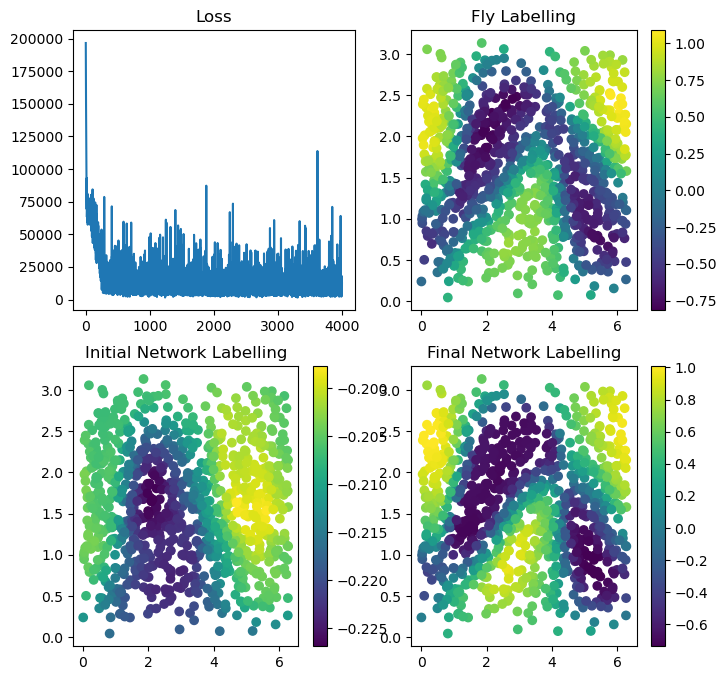

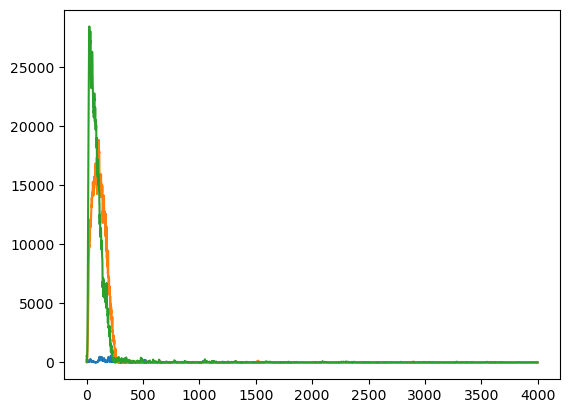

In [20]:
# Next up, let's try to get the second eigenfunction

# Set up optimiser and loss
model4 = NeuralNet(input_size_gen, hidden_size_gen, output_size_gen)
optimizer = optim.Adagrad(model4.parameters(), lr=0.01)


# Parameter choices
M = 30 # Number of datapoints for each training step
T = 4000 # Number of steps
M_plot = 1000 # number of points for plotting
Losses = np.zeros(T)
Loss_orthog_1 = np.zeros(T)
Loss_orthog_2 = np.zeros(T)
Loss_orthog_3 = np.zeros(T)


# Get initial labelling
x_plot = new_data(M_plot)
z_init = model4(x_plot).detach().numpy()
z_orth_1 = torch.tensor(z1)
z_orth_2 = torch.tensor(z2)
z_orth_3 = torch.tensor(z3)

for step in range(T):
  optimizer.zero_grad()
  x_tr = new_data(M//5)
  x_te = new_data(M)
  z_tr = model4(x_tr)
  z_te = model4(x_te)
  z_comp1 = model4(x1)
  z_comp2 = model4(x2)
  z_comp3 = model4(x3)
  J = np.transpose(np.random.multivariate_normal(np.zeros(3),[[1,0,0],[0,1,0],[0,0,c]], (K)))
  J = torch.from_numpy(J).float()
  loss, orthog_loss_1, orthog_loss_2, orthog_loss_3 = loss_orthog_kernel_learnt_3(x_tr, x_te, z_tr, z_te, z_comp1, z_comp2, z_comp3, z_orth_1, z_orth_2, z_orth_3, distr, J)
  Loss_orthog_1[step] = orthog_loss_1
  Loss_orthog_2[step] = orthog_loss_2
  Loss_orthog_3[step] = orthog_loss_3
  loss.backward()
  optimizer.step()
  Losses[step] = loss.item()

z = model4(x_plot).detach()
fly_label = fly_simple_kernel_learnt(x_plot, z, J).numpy()
z = model4(x_plot).detach().numpy()
y = threeto2D(x_plot.detach().numpy())


plotty_dotty(Losses, y, fly_label, z_init, z)
x4 = x_plot
z4 = z

x_plot = new_data(M_plot)
z_learnt = model3(x_plot)
z_1 = model(x_plot)
z_2 = model2(x_plot)
z_3 = model3(x_plot)

print(f'Orthogonality: {torch.sum(torch.multiply(z_1[:,0], z_learnt[:,0]))**2/M_plot}')
print(f'Orthogonality: {torch.sum(torch.multiply(z_2[:,0], z_learnt[:,0]))**2/M_plot}')
print(f'Orthogonality: {torch.sum(torch.multiply(z_3[:,0], z_learnt[:,0]))**2/M_plot}')

plt.figure()
plt.plot(Loss_orthog_1)
plt.plot(Loss_orthog_2)
plt.plot(Loss_orthog_3)

In [21]:
def loss_orthog_kernel_learnt_4(x_tr, x_te, z_tr, z_te, z_func1, z_func2, z_func3, z_func4, z1, z2, z3, z4, distr, J):
  y_tr = torch.nn.functional.relu(torch.matmul(x_tr,J))
  w = torch.matmul(torch.inverse(torch.matmul(torch.transpose(y_tr,0,1), y_tr) + 0.001*torch.eye(K)),torch.matmul(torch.transpose(y_tr,0,1), z_tr))
  y_te = torch.nn.functional.relu(torch.matmul(x_te,J))
  fly_label = torch.matmul(y_te, w)

  label_loss = torch.mean((z_te - fly_label)**2)
  loss = SamplesLoss(loss="sinkhorn", p=2, blur=.05)
  dist_loss = 1000000*(loss(z_te, distr))

  orthog_loss_1 = torch.sum(torch.multiply(z1[:,0], z_func1[:,0]))**2
  orthog_loss_2 = torch.sum(torch.multiply(z2[:,0], z_func2[:,0]))**2
  orthog_loss_3 = torch.sum(torch.multiply(z3[:,0], z_func3[:,0]))**2
  orthog_loss_4 = torch.sum(torch.multiply(z4[:,0], z_func4[:,0]))**2
  orthog_loss = orthog_loss_1 + orthog_loss_2 + orthog_loss_3 + orthog_loss_4

  #print(f"Label loss: {label_loss}, Orthog loss: {orthog_loss}, Dist loss: {dist_loss}")
  #print(f"Orthog 1: {orthog_loss_1}, Orthog 2: {orthog_loss_2}, Orthog 3: {orthog_loss_3}, Orthog 4: {orthog_loss_4}")

  return dist_loss + label_loss + orthog_loss, orthog_loss_1, orthog_loss_2, orthog_loss_3, orthog_loss_4 

Orthogonality: 0.002345485845580697
Orthogonality: 0.05885941907763481
Orthogonality: 0.7463428974151611
Orthogonality: 0.0038679393474012613


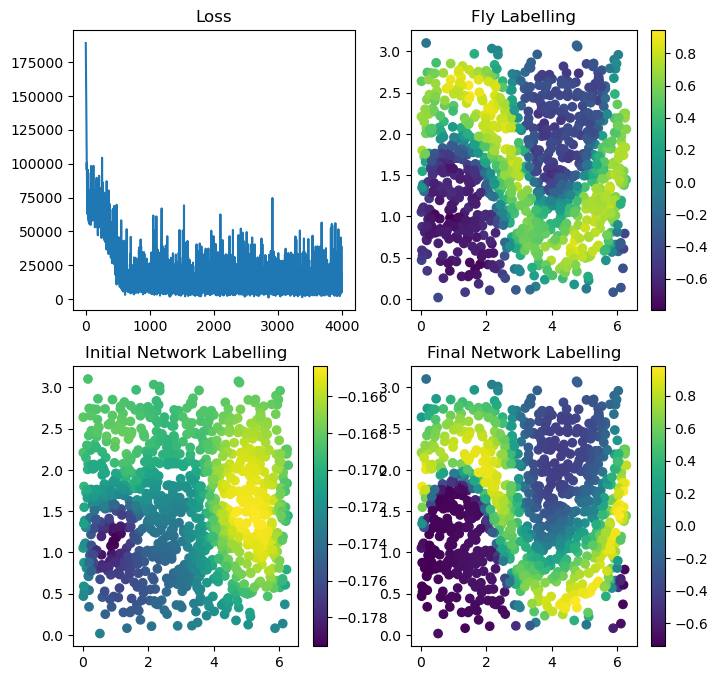

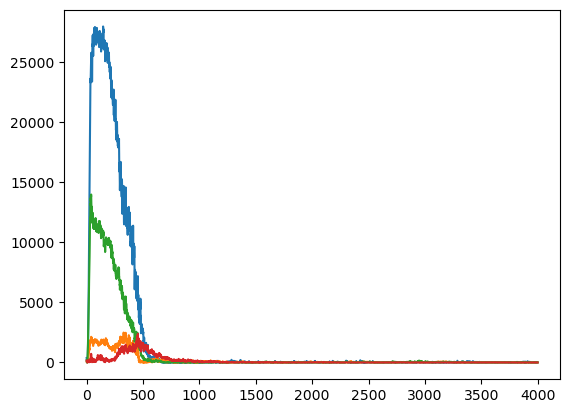

In [22]:
# Next up, let's try to get the second eigenfunction

# Set up optimiser and loss
model5 = NeuralNet(input_size_gen, hidden_size_gen, output_size_gen)
optimizer = optim.Adagrad(model5.parameters(), lr=0.01)

# Parameter choices
M = 30 # Number of datapoints for each training step
T = 4000 # Number of steps
M_plot = 1000 # number of points for plotting
Losses = np.zeros(T)
Loss_orthog_1 = np.zeros(T)
Loss_orthog_2 = np.zeros(T)
Loss_orthog_3 = np.zeros(T)
Loss_orthog_4 = np.zeros(T)

# Get initial labelling
x_plot = new_data(M_plot)
z_init = model5(x_plot).detach().numpy()
z_orth_1 = torch.tensor(z1)
z_orth_2 = torch.tensor(z2)
z_orth_3 = torch.tensor(z3)
z_orth_4 = torch.tensor(z4)

for step in range(T):
  optimizer.zero_grad()
  x_tr = new_data(M//5)
  x_te = new_data(M)
  z_tr = model5(x_tr)
  z_te = model5(x_te)
  z_comp1 = model5(x1)
  z_comp2 = model5(x2)
  z_comp3 = model5(x3)
  z_comp4 = model5(x4)
  J = np.transpose(np.random.multivariate_normal(np.zeros(3),[[1,0,0],[0,1,0],[0,0,c]], (K)))
  J = torch.from_numpy(J).float()
  loss, orthog_loss_1, orthog_loss_2, orthog_loss_3, orthog_loss_4  = loss_orthog_kernel_learnt_4(x_tr, x_te, z_tr, z_te, z_comp1, z_comp2, z_comp3, z_comp4, z_orth_1, z_orth_2, z_orth_3, z_orth_4, distr, J)
  loss.backward()
  optimizer.step()
  Loss_orthog_1[step] = orthog_loss_1
  Loss_orthog_2[step] = orthog_loss_2
  Loss_orthog_3[step] = orthog_loss_3
  Loss_orthog_4[step] = orthog_loss_4
  Losses[step] = loss.item()

z = model5(x_plot).detach()
fly_label = fly_simple_kernel_learnt(x_plot, z, J).numpy()
z = model5(x_plot).detach().numpy()
y = threeto2D(x_plot.detach().numpy())


plotty_dotty(Losses, y, fly_label, z_init, z)
x5 = x_plot
z5 = z

x_plot = new_data(M_plot)
z_learnt = model5(x_plot)
z_1 = model(x_plot)
z_2 = model2(x_plot)
z_3 = model3(x_plot)
z_4 = model4(x_plot)

print(f'Orthogonality: {torch.sum(torch.multiply(z_1[:,0], z_learnt[:,0]))**2/M_plot}')
print(f'Orthogonality: {torch.sum(torch.multiply(z_2[:,0], z_learnt[:,0]))**2/M_plot}')
print(f'Orthogonality: {torch.sum(torch.multiply(z_3[:,0], z_learnt[:,0]))**2/M_plot}')
print(f'Orthogonality: {torch.sum(torch.multiply(z_4[:,0], z_learnt[:,0]))**2/M_plot}')

plt.figure()
plt.plot(Loss_orthog_1)
plt.plot(Loss_orthog_2)
plt.plot(Loss_orthog_3)
plt.plot(Loss_orthog_4)

In [23]:
def loss_orthog_kernel_learnt_5(x_tr, x_te, z_tr, z_te, z_func1, z_func2, z_func3, z_func4, z_func5, z1, z2, z3, z4, z5, distr, J):
  y_tr = torch.nn.functional.relu(torch.matmul(x_tr,J))
  w = torch.matmul(torch.inverse(torch.matmul(torch.transpose(y_tr,0,1), y_tr) + 0.001*torch.eye(K)),torch.matmul(torch.transpose(y_tr,0,1), z_tr))
  y_te = torch.nn.functional.relu(torch.matmul(x_te,J))
  fly_label = torch.matmul(y_te, w)

  label_loss = torch.mean((z_te - fly_label)**2)
  loss = SamplesLoss(loss="sinkhorn", p=2, blur=.05)
  dist_loss = 1000000*(loss(z_te, distr))

  orthog_loss_1 = torch.sum(torch.multiply(z1[:,0], z_func1[:,0]))**2
  orthog_loss_2 = torch.sum(torch.multiply(z2[:,0], z_func2[:,0]))**2
  orthog_loss_3 = torch.sum(torch.multiply(z3[:,0], z_func3[:,0]))**2
  orthog_loss_4 = torch.sum(torch.multiply(z4[:,0], z_func4[:,0]))**2
  orthog_loss_5 = torch.sum(torch.multiply(z5[:,0], z_func5[:,0]))**2
  orthog_loss = orthog_loss_1 + orthog_loss_2 + orthog_loss_3 + orthog_loss_4 + orthog_loss_5

  #print(f"Label loss: {label_loss}, Orthog loss: {orthog_loss}, Dist loss: {dist_loss}")
  #print(f"Orthog 1: {orthog_loss_1}, Orthog 2: {orthog_loss_2}, Orthog 3: {orthog_loss_3}, Orthog 4: {orthog_loss_4}")

  return dist_loss + label_loss + orthog_loss, orthog_loss_1, orthog_loss_2, orthog_loss_3, orthog_loss_4, orthog_loss_5

In [ ]:
# Next up, let's try to get the second eigenfunction

# Set up optimiser and loss
model6 = NeuralNet(input_size_gen, hidden_size_gen, output_size_gen)
optimizer = optim.Adagrad(model6.parameters(), lr=0.01)
Losses = np.zeros(T)

# Parameter choices
M = 30 # Number of datapoints for each training step
T = 5000 # Number of steps
M_plot = 1000 # number of points for plotting
Losses = np.zeros(T)
Loss_orthog_1 = np.zeros(T)
Loss_orthog_2 = np.zeros(T)
Loss_orthog_3 = np.zeros(T)
Loss_orthog_4 = np.zeros(T)
Loss_orthog_5 = np.zeros(T)

# Get initial labelling
x_plot = new_data(M_plot)
z_init = model6(x_plot).detach().numpy()
z_orth_1 = torch.tensor(z1)
z_orth_2 = torch.tensor(z2)
z_orth_3 = torch.tensor(z3)
z_orth_4 = torch.tensor(z4)
z_orth_5 = torch.tensor(z5)

for step in range(T):
  optimizer.zero_grad()
  x_tr = new_data(M//5)
  x_te = new_data(M)
  z_tr = model6(x_tr)
  z_te = model6(x_te)
  z_comp1 = model6(x1)
  z_comp2 = model6(x2)
  z_comp3 = model6(x3)
  z_comp4 = model6(x4)
  z_comp5 = model6(x5)
  J = np.transpose(np.random.multivariate_normal(np.zeros(3),[[1,0,0],[0,1,0],[0,0,c]], (K)))
  J = torch.from_numpy(J).float()
  loss, orthog_loss_1, orthog_loss_2, orthog_loss_3, orthog_loss_4, orthog_loss_5 = loss_orthog_kernel_learnt_5(x_tr, x_te, z_tr, z_te, z_comp1, z_comp2, z_comp3, z_comp4, z_comp5, z_orth_1, z_orth_2, z_orth_3, z_orth_4, z_orth_5, distr, J)
  loss.backward(retain_graph=True)
  optimizer.step()
  Loss_orthog_1[step] = orthog_loss_1
  Loss_orthog_2[step] = orthog_loss_2
  Loss_orthog_3[step] = orthog_loss_3
  Loss_orthog_4[step] = orthog_loss_4
  Loss_orthog_5[step] = orthog_loss_5
  Losses[step] = loss.item()

z = model6(x_plot).detach()
fly_label = fly_simple_kernel_learnt(x_plot, z, J).numpy()
z = model6(x_plot).detach().numpy()
y = threeto2D(x_plot.detach().numpy())


plotty_dotty(Losses, y, fly_label, z_init, z)
x6 = x_plot
z6 = z

x_plot = new_data(M_plot)
z_learnt = model6(x_plot)
z_1 = model(x_plot)
z_2 = model2(x_plot)
z_3 = model3(x_plot)
z_4 = model4(x_plot)
z_5 = model5(x_plot)

print(f'Orthogonality: {torch.sum(torch.multiply(z_1[:,0], z_learnt[:,0]))**2/M_plot}')
print(f'Orthogonality: {torch.sum(torch.multiply(z_2[:,0], z_learnt[:,0]))**2/M_plot}')
print(f'Orthogonality: {torch.sum(torch.multiply(z_3[:,0], z_learnt[:,0]))**2/M_plot}')
print(f'Orthogonality: {torch.sum(torch.multiply(z_4[:,0], z_learnt[:,0]))**2/M_plot}')
print(f'Orthogonality: {torch.sum(torch.multiply(z_5[:,0], z_learnt[:,0]))**2/M_plot}')

plt.figure()
plt.plot(Loss_orthog_1)
plt.plot(Loss_orthog_2)
plt.plot(Loss_orthog_3)
plt.plot(Loss_orthog_4)
plt.plot(Loss_orthog_5)

In [ ]:
M_plot = 2000
x_plot = new_data(M_plot)
y = threeto2D(x_plot)
z1 = model(x_plot).detach().numpy()
z2 = model2(x_plot).detach().numpy()
z3 = model3(x_plot).detach().numpy()
z4 = model4(x_plot).detach().numpy()
z5 = model5(x_plot).detach().numpy()
z6 = model6(x_plot).detach().numpy()
def eig_plot_real(z1, z2, z3, z4, z5, z6, x_plot):
  y = threeto2D(x_plot)
  plt.figure(figsize = (12, 6))

  # Plot three different labellings
  plt.subplot(2,3,1)
  plt.scatter(y[:,0], y[:,1], c = z1)
  plt.colorbar()
  plt.title('Eigenfunction 1' + str())
  plt.subplot(2,3,2)
  plt.scatter(y[:,0], y[:,1], c = z2)
  plt.colorbar()
  plt.title('Eigenfunction 2' +str())
  plt.subplot(2,3,3)
  plt.scatter(y[:,0], y[:,1], c = z3)
  plt.colorbar()
  plt.title('Eigenfunction 3' +str())
  plt.subplot(2,3,4)
  plt.scatter(y[:,0], y[:,1], c = z4)
  plt.colorbar()
  plt.title('Eigenfunction 4' +str())
  plt.subplot(2,3,5)
  plt.scatter(y[:,0], y[:,1], c = z5)
  plt.colorbar()
  plt.title('Eigenfunction 5' +str())
  plt.subplot(2,3,6)
  plt.scatter(y[:,0], y[:,1], c = z6)
  plt.colorbar()
  plt.title('Eigenfunction 6' +str())

In [ ]:
eig_plot_real(z1, z2, z3, z4, z5, z6, x_plot)
plt.savefig('Biased_Connectivity.svg')

In [ ]:
def threeto2Dsphharm(x):
  y = np.zeros([x.shape[0], 2])
  y[:,0] = np.arctan2(x[:,1],x[:,0])+torch.pi
  y[:,1] = np.arctan2(x[:,2],np.sqrt(np.power(x[:,0],2) + np.power(x[:,1],2)))+torch.pi/2
  return y

def convert_sph(m,n,y):
  if m < 0:
    sph = 2**(1/2)*(-1)**m*(special.sph_harm(abs(m), n, y[:,0], y[:,1]).imag)
  elif m == 0:
    sph = special.sph_harm(0, n, y[:,0], y[:,1])
  elif m > 0:
    sph = 2**(1/2)*(-1)**m*(special.sph_harm(m, n, y[:,0], y[:,1]).real)
  return sph

def sph_harm_plots(x):
  y = threeto2Dsphharm(x)
  #limit = torch.max(x)
  plt.figure(figsize = (12,8))
  ploty = 0
  for n in range(0,4):
    for m in range(-n, n+1, 1):
      sph = convert_sph(m,n,y)
      plt.subplot(4,4,ploty+1)
      plt.scatter(y[:,0], y[:,1], c = sph)
      plt.colorbar()
      plt.title(f'{ploty}"th sph harm {n,m}')
      frame1 = plt.gca()
      frame1.axes.get_xaxis().set_visible(False)
      frame1.axes.get_yaxis().set_visible(False)
      ploty+=1
    
sph_harm_plots(x_plot)

In [ ]:
def sph_harm_func(x, n):
  '''
  This function produces spherical harmonics for the first n, where n is quantum number l.
  Output: sph_all: torch.tensor, size = [16,1000]
          16 - number of harmonic functions with different pairs n, m
          1000 - number of data points
  '''
  y = threeto2Dsphharm(x)
  plt.figure(figsize = (12,8))
  sph_all = []
  for i in range(n+1):
    for m in range(-i, i+1, 1):
      sph = convert_sph(m,i,y)
      sph_all.append(sph.real)
  sph_all = torch.tensor(sph_all)
  return sph_all
sph_all = sph_harm_func(x_plot, 10)
print(sph_all.shape)


In [ ]:
def dot_sph_func(sph_all, z):
  '''
  This function calculates the products of the model function with the spherical harmonics
  Output: val - proportion of each spherical harmonic function in the z function
          product - dot product of each spherical harmonics with z

  '''
  z = torch.flatten(z)
  product = torch.zeros((sph_all.shape[0],1))
  val = torch.zeros(product.shape)
  sph_all = sph_all.float()
  for i in range(sph_all.shape[0]):
    #product[i,:] = torch.arccos(torch.dot(sph_all[i,:],z)/(torch.sqrt((sph_all[i,:]**2).sum())*torch.sqrt((z**2).sum())))
    product[i,:] = torch.dot(sph_all[i,:],z)
  val = torch.absolute(product)/torch.sum(torch.absolute(product))
  return val, product

val, product = dot_sph_func(sph_all, torch.tensor(z1))
plt.plot(product)
plt.plot(val)


In [ ]:
for z in [z1, z2, z3, z4, z5, z6]:
    val, product = dot_sph_func(sph_all, torch.tensor(z))
    first_order = np.sqrt(torch.sum(val[1:4]**2)/torch.sum(val**2))
    second_order = np.sqrt(torch.sum(val[4:9]**2)/torch.sum(val**2))
    print(first_order)
    print(second_order)

In [ ]:
M_plot = 5000
x_plot = new_data(M_plot)
z = model(x_plot).detach()
fly_label = fly_simple_kernel_learnt(x_plot, z, J).numpy()
z_1 = z.numpy()
MSE_1 = np.sum((fly_label - z_1)**2)/(2*M_plot)

z = model2(x_plot).detach()
fly_label = fly_simple_kernel_learnt(x_plot, z, J).numpy()
z_2 = z.numpy()
MSE_2 = np.sum((fly_label - z_2)**2)/(2*M_plot)

z = model3(x_plot).detach()
fly_label = fly_simple_kernel_learnt(x_plot, z, J).numpy()
z_3 = z.numpy()
MSE_3 = np.sum((fly_label - z_3)**2)/(2*M_plot)

z = model4(x_plot).detach()
fly_label = fly_simple_kernel_learnt(x_plot, z, J).numpy()
z_4 = z.numpy()
MSE_4 = np.sum((fly_label - z_4)**2)/(2*M_plot)

z = model5(x_plot).detach()
fly_label = fly_simple_kernel_learnt(x_plot, z, J).numpy()
z_5 = z.numpy()
MSE_5 = np.sum((fly_label - z_5)**2)/(2*M_plot)

z = model6(x_plot).detach()
fly_label = fly_simple_kernel_learnt(x_plot, z, J).numpy()
z_6 = z.numpy()
MSE_6 = np.sum((fly_label - z_6)**2)/(2*M_plot)

print(MSE_1)
print(MSE_2)
print(MSE_3)
print(MSE_4)
print(MSE_5)
print(MSE_6)